#AI VIET NAM
#Advanced CNN Architecture

##**1. ResNet18**

###**Load ResNet18 Model**

In [ ]:
import torch

from torchvision import models
from torchsummary import summary

In [ ]:
resnet_model = models.resnet18(weights=None)

In [ ]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

**Example**

In [ ]:
inputs = torch.randint(5, (32, 3, 224, 224), dtype=torch.float32)

In [ ]:
predictions = resnet_model(inputs)

In [ ]:
predictions.shape

torch.Size([32, 1000])

###**CIFAR10 Classification**

In [ ]:
import os
import time

import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms, models
import torch.utils.data as data
from torch.utils.data import DataLoader

from torchsummary import summary

import matplotlib.pyplot as plt

####**Download Dataset**

In [ ]:
ROOT = './data'

train_data = datasets.CIFAR10(
    root=ROOT,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.CIFAR10(
    root=ROOT,
    train=False,
    download=True,
    transform=transforms.ToTensor()
    )

100%|██████████| 170498071/170498071 [00:05<00:00, 29900030.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(train_data)

50000

In [ ]:
train_data.data.shape

(50000, 32, 32, 3)

In [ ]:
len(test_data)

10000

####Preprocessing

**Compute mean and std**

In [ ]:
train_data_stack = torch.stack([img for img, _ in train_data], dim=3)

In [ ]:
train_data_stack.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
mean= train_data_stack.view(3,-1).mean(dim=1)
std= train_data_stack.view(3,-1).std(dim=1)
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

**Transform**

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_data.transform = data_transforms
test_data.transform = data_transforms

In [ ]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [ ]:
len(train_dataloader)

98

In [ ]:
inputs, labels = next(iter(train_dataloader))

In [ ]:
inputs.shape

torch.Size([512, 3, 32, 32])

####Trainer

In [ ]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

####**Training**

In [ ]:
model = models.resnet18(weights=None)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(train_data.classes))

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model = models.resnet18(weights=None)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(train_data.classes))
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, device
)

| epoch   1 |    50/   98 batches | accuracy    0.293
-----------------------------------------------------------
| End of epoch   1 | Time: 24.11s | Train Accuracy    0.443 | Train Loss    1.804 | Valid Accuracy    0.465 | Valid Loss    1.459 
-----------------------------------------------------------
| epoch   2 |    50/   98 batches | accuracy    0.510
-----------------------------------------------------------
| End of epoch   2 | Time: 24.22s | Train Accuracy    0.560 | Train Loss    1.301 | Valid Accuracy    0.513 | Valid Loss    1.402 
-----------------------------------------------------------
| epoch   3 |    50/   98 batches | accuracy    0.622
-----------------------------------------------------------
| End of epoch   3 | Time: 24.48s | Train Accuracy    0.646 | Train Loss    1.038 | Valid Accuracy    0.597 | Valid Loss    1.191 
-----------------------------------------------------------
| epoch   4 |    50/   98 batches | accuracy    0.684
-------------------------------

In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.746, 1.3804279565811157)

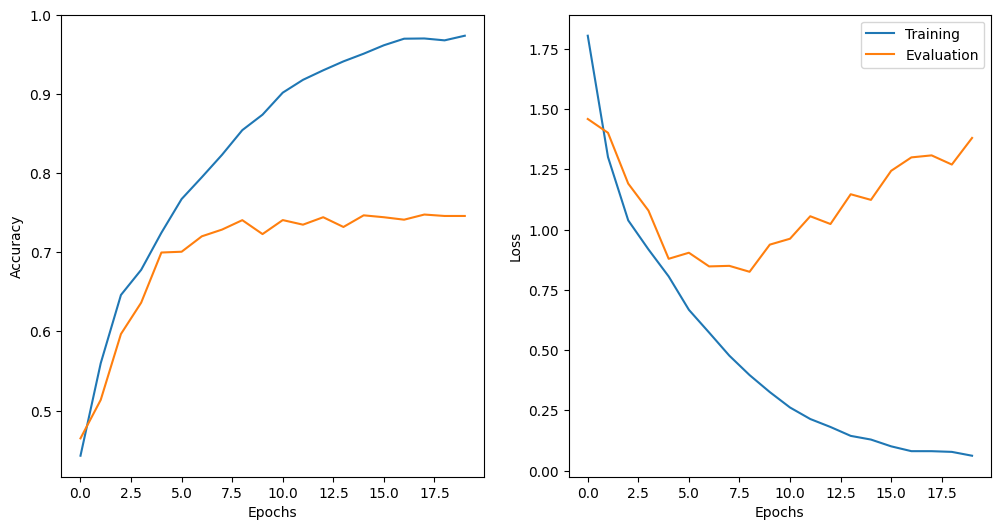

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

##**2. Pretrained Models**

In [ ]:
pretrained_model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [ ]:
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# remove classifier layer (block)
resnet_feature_extractor = nn.Sequential(
    *list(pretrained_model.children())[:-1]
)

resnet_feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
resnet_feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
resnet_feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
train_data.data[4]

array([[[170, 180, 198],
        [168, 178, 196],
        [177, 185, 203],
        ...,
        [162, 179, 215],
        [158, 178, 214],
        [157, 177, 212]],

       [[168, 181, 198],
        [172, 185, 201],
        [171, 183, 200],
        ...,
        [159, 177, 212],
        [156, 176, 211],
        [154, 174, 209]],

       [[154, 170, 186],
        [149, 165, 181],
        [129, 144, 162],
        ...,
        [161, 178, 214],
        [157, 177, 212],
        [154, 174, 209]],

       ...,

       [[ 74,  84,  80],
        [ 76,  85,  81],
        [ 78,  85,  82],
        ...,
        [ 71,  75,  78],
        [ 68,  72,  75],
        [ 61,  65,  68]],

       [[ 68,  76,  77],
        [ 69,  77,  78],
        [ 72,  79,  78],
        ...,
        [ 76,  80,  83],
        [ 71,  75,  78],
        [ 71,  75,  78]],

       [[ 67,  75,  78],
        [ 68,  76,  79],
        [ 69,  75,  76],
        ...,
        [ 75,  79,  82],
        [ 71,  75,  78],
        [ 73,  77,  80]]

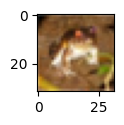

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(train_data.data[0])

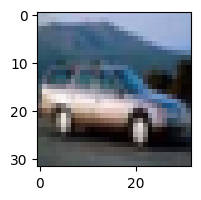

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(train_data.data[4])

In [ ]:
train_data.data[4].shape

(32, 32, 3)

In [ ]:
processed_image = data_transforms(train_data.data[4])

In [ ]:
processed_image.shape

torch.Size([3, 32, 32])

In [ ]:
processed_image

tensor([[[-1.0526e+00, -1.3066e+00, -1.1955e+00,  ...,  5.1899e-01,
           4.2375e-01,  3.6025e-01],
         [-1.7352e+00, -1.9892e+00, -1.7035e+00,  ..., -3.6622e-02,
          -1.0012e-01, -5.2496e-02],
         [-1.5923e+00, -1.7352e+00, -1.2114e+00,  ..., -1.1600e-01,
          -8.4246e-02, -2.5887e-01],
         ...,
         [ 1.3127e+00,  1.2016e+00,  1.1540e+00,  ...,  5.5074e-01,
          -1.1002e+00, -1.1479e+00],
         [ 8.6824e-01,  7.5711e-01,  9.6349e-01,  ...,  9.3174e-01,
          -4.4936e-01, -6.7161e-01],
         [ 8.2061e-01,  6.7774e-01,  8.5236e-01,  ...,  1.4397e+00,
           4.0787e-01, -3.6622e-02]],

        [[-9.8167e-01, -1.2394e+00, -1.2072e+00,  ...,  1.4575e-01,
           3.3011e-02,  1.6905e-02],
         [-1.6581e+00, -1.9802e+00, -1.8514e+00,  ..., -5.6291e-01,
          -6.4344e-01, -5.7902e-01],
         [-1.5937e+00, -1.8675e+00, -1.5454e+00,  ..., -6.2733e-01,
          -6.2733e-01, -8.0450e-01],
         ...,
         [ 7.5778e-01,  4

In [ ]:
processed_image.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [ ]:
prediction = resnet_feature_extractor(processed_image.unsqueeze(0))

In [ ]:
prediction.squeeze().shape

torch.Size([512])

In [ ]:
prediction.squeeze().shape

torch.Size([512])

##**3. Image Similarity**

In [1]:
import torch
import torch.nn as nn

### L1 Distance - Absolute distance

In [2]:
def l1_distance(tensor1, tensor2):
    return torch.sum(torch.abs(tensor1 - tensor2))

### L2 Distance - Euclidean distance

In [4]:
def mse(tensor1, tensor2):
    return torch.sqrt(torch.mean((tensor1 - tensor2) ** 2))

### Cosine similarity

In [5]:
def cosine_similarity(tensor1, tensor2):
    return torch.nn.functional.cosine_similarity(tensor1, tensor2, dim=0)

In [6]:
def cosine_similarity_v2(tensor1, tensor2):
    tensor1_norm  = torch.norm(tensor1)
    tensor2_norm  = torch.norm(tensor2)
    return torch.dot(tensor1, tensor2) / (tensor1_norm * tensor2_norm)

In [7]:
# Create two tensors
tensor1 = torch.tensor([1.0, 2.0, 3.0])
tensor2 = torch.tensor([4.0, 5.0, 6.0])

In [8]:
print("Cosine Similarity:", cosine_similarity(tensor1, tensor2))
print("Cosine Similarity V2:", cosine_similarity_v2(tensor1, tensor2))

Cosine Similarity: tensor(0.9746)
Cosine Similarity V2: tensor(0.9746)


In [ ]:
### Normalized Cross Correlation

In [9]:
def normalized_cross_correlation(tensor1, tensor2):
    mean1 = torch.mean(tensor1)
    mean2 = torch.mean(tensor2)

    # Calculate the centered tensors
    centered1 = tensor1 - mean1
    centered2 = tensor2 - mean2

    # Calculate the NCC
    return torch.sum(centered1 * centered2) / (torch.sqrt(torch.sum(centered1 ** 2)) * torch.sqrt(torch.sum(centered2 ** 2)))

In [10]:
# Create two tensors
tensor1 = torch.tensor([1.0, 2.0, 3.0])
tensor2 = torch.tensor([4.0, 6.0, 6.0])

normalized_cross_correlation(tensor1, tensor2)

tensor(0.8660)

### Similarity On Images

In [11]:
!gdown 1ZpbgBCosHuPqADxb0Bzg8KOVRZB--ooU
!gdown 1aXAFjikFsS6NiRaBwULbd8y-4OGOVw0_
!gdown 1oX0Id3Ri5B7cAKyettcuzjdKt0JrX-li
!gdown 1r4fvrTcWFWEck-hN0QMdECMmwVsLGTVU

Downloading...
From: https://drive.google.com/uc?id=1ZpbgBCosHuPqADxb0Bzg8KOVRZB--ooU
To: /content/Airplane.png
100% 33.1k/33.1k [00:00<00:00, 82.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aXAFjikFsS6NiRaBwULbd8y-4OGOVw0_
To: /content/Dog1.png
100% 769k/769k [00:00<00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oX0Id3Ri5B7cAKyettcuzjdKt0JrX-li
To: /content/Dog2.jpg
100% 1.34M/1.34M [00:00<00:00, 96.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r4fvrTcWFWEck-hN0QMdECMmwVsLGTVU
To: /content/Dog3.png
100% 502k/502k [00:00<00:00, 164MB/s]


In [12]:
from PIL import Image
from IPython.display import display

image_dog1 = Image.open("/content/Dog1.png").resize((224, 224)).convert('RGB')
image_dog2 = Image.open("/content/Dog2.jpg").resize((224, 224)).convert('RGB')
image_dog3 = Image.open("/content/Dog3.png").resize((224, 224)).convert('RGB')
image_airplane = Image.open("/content/Airplane.png").resize((224, 224)).convert('RGB')

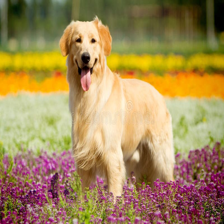

In [13]:
display(image_dog1)

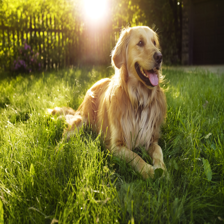

In [14]:
display(image_dog2)

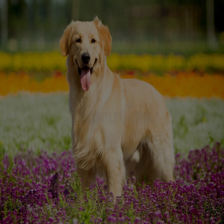

In [15]:
display(image_dog3)

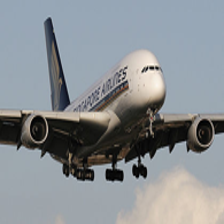

In [16]:
display(image_airplane)

In [17]:
# to pytorch tensor
import torchvision.transforms as T

transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

tensor_dog1 = transforms(image_dog1)
tensor_dog2 = transforms(image_dog2)
tensor_dog3 = transforms(image_dog3)
tensor_airplane = transforms(image_airplane)

In [18]:
print(tensor_dog1.shape, tensor_dog2.shape, tensor_airplane.shape)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


In [19]:
# between dog 1 and dog 2
l1_dist_1 = l1_distance(tensor_dog1, tensor_dog2)
l2_dist_1 = mse(tensor_dog1, tensor_dog2)
cosine_sim_1 = cosine_similarity(tensor_dog1.view(-1), tensor_dog2.view(-1))
cross_corr_1 = normalized_cross_correlation(tensor_dog1, tensor_dog2)

In [20]:
print("L1 Distance: ", l1_dist_1)
print("L2 Distance: ", l2_dist_1)
print("Cosine similarity: ", cosine_sim_1)
print("Normalized Cross Correlation: ", cross_corr_1)

L1 Distance:  tensor(40339.4766)
L2 Distance:  tensor(0.3265)
Cosine similarity:  tensor(0.8294)
Normalized Cross Correlation:  tensor(0.3937)


In [21]:
# between dog1 and airplane
l1_dist_2 = l1_distance(tensor_dog1, tensor_airplane)
l2_dist_2 = mse(tensor_dog1, tensor_airplane)
cosine_sim_2 = cosine_similarity(tensor_dog1.view(-1), tensor_airplane.view(-1))
cross_corr_2 = normalized_cross_correlation(tensor_dog1, tensor_airplane)

In [22]:
print("L1 Distance: ", l1_dist_2)
print("L2 Distance: ", l2_dist_2)
print("Cosine similarity: ", cosine_sim_2)
print("Normalized Cross Correlation: ", cross_corr_2)

L1 Distance:  tensor(51128.4297)
L2 Distance:  tensor(0.4063)
Cosine similarity:  tensor(0.7620)
Normalized Cross Correlation:  tensor(-0.3564)


In [23]:
# between dog1 and dog3
l1_dist_3 = l1_distance(tensor_dog1, tensor_dog3)
l2_dist_3 = mse(tensor_dog1, tensor_dog3)
cosine_sim_3 = cosine_similarity(tensor_dog1.view(-1), tensor_dog3.view(-1))
cross_corr_3 = normalized_cross_correlation(tensor_dog1, tensor_dog3)

In [24]:
print("L1 Distance: ", l1_dist_3)
print("L2 Distance: ", l2_dist_3)
print("Cosine similarity: ", cosine_sim_3)
print("Normalized Cross Correlation: ", cross_corr_3)

L1 Distance:  tensor(38637.2266)
L2 Distance:  tensor(0.2894)
Cosine similarity:  tensor(1.0000)
Normalized Cross Correlation:  tensor(0.9999)


###Using ResNet18

In [25]:
import torchvision
from torchvision import models

model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [26]:
model.fc = nn.Identity()

In [27]:
dog1_feature = model(tensor_dog1.unsqueeze(0))
dog2_feature = model(tensor_dog2.unsqueeze(0))
dog3_feature =  model(tensor_dog3.unsqueeze(0))
airplane_feature =  model(tensor_airplane.unsqueeze(0))

In [28]:
# between dog1 and dog2
l1_dist_4 = l1_distance(dog1_feature, dog2_feature)
l2_dist_4 = mse(dog1_feature, dog2_feature)
cosine_sim_4 = cosine_similarity(dog1_feature[0], dog2_feature[0])
cross_corr_4 = normalized_cross_correlation(dog1_feature, dog2_feature)

In [29]:
print("L1 Distance: ", l1_dist_4)
print("L2 Distance: ", l2_dist_4)
print("Cosine similarity: ", cosine_sim_4)
print("Normalized Cross Correlation: ", cross_corr_4)

L1 Distance:  tensor(21.8049, grad_fn=<SumBackward0>)
L2 Distance:  tensor(0.0532, grad_fn=<SqrtBackward0>)
Cosine similarity:  tensor(0.9986, grad_fn=<SumBackward1>)
Normalized Cross Correlation:  tensor(0.8285, grad_fn=<DivBackward0>)


In [30]:
# between dog1 and airplane
l1_dist_5 = l1_distance(dog1_feature, airplane_feature)
l2_dist_5 = mse(dog1_feature, airplane_feature)
cosine_sim_5 = cosine_similarity(dog1_feature[0], airplane_feature[0])
cross_corr_5 = normalized_cross_correlation(dog1_feature, airplane_feature)

In [31]:
print("L1 Distance: ", l1_dist_5)
print("L2 Distance: ", l2_dist_5)
print("Cosine similarity: ", cosine_sim_5)
print("Normalized Cross Correlation: ", cross_corr_5)

L1 Distance:  tensor(24.4272, grad_fn=<SumBackward0>)
L2 Distance:  tensor(0.0594, grad_fn=<SqrtBackward0>)
Cosine similarity:  tensor(0.9981, grad_fn=<SumBackward1>)
Normalized Cross Correlation:  tensor(0.7309, grad_fn=<DivBackward0>)


In [32]:
# between dog1 and dog3
l1_dist_6 = l1_distance(dog1_feature, dog3_feature)
l2_dist_6 = mse(dog1_feature, dog3_feature)
cosine_sim_6 = cosine_similarity(dog1_feature[0], dog3_feature[0])
cross_corr_6 = normalized_cross_correlation(dog1_feature, dog3_feature)

In [33]:
print("L1 Distance: ", l1_dist_6)
print("L2 Distance: ", l2_dist_6)
print("Cosine similarity: ", cosine_sim_6)
print("Normalized Cross Correlation: ", cross_corr_6)

L1 Distance:  tensor(2.0186, grad_fn=<SumBackward0>)
L2 Distance:  tensor(0.0053, grad_fn=<SqrtBackward0>)
Cosine similarity:  tensor(1.0000, grad_fn=<SumBackward1>)
Normalized Cross Correlation:  tensor(0.9979, grad_fn=<DivBackward0>)
